## Example of AnnDataLoader usage for integration with CVAE

In [1]:
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist

import numpy as np
import scanpy as sc

from anndata.dev.pytorch import AnnDataLoader
from sklearn.preprocessing import OneHotEncoder

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super().__init__()
        
        modules = []
        for in_size, out_size in zip([input_dim]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.LayerNorm(out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.05))
        modules.append(nn.Linear(hidden_dims[-1], out_dim))
        self.fc = nn.Sequential(*modules)
    
    def forward(self, *inputs):
        input_cat = torch.cat(inputs, dim=-1)
        return self.fc(input_cat)

In [3]:
class CVAE(nn.Module):
    def __init__(self, input_dim, n_conds, hidden_dims, latent_dim):
        super().__init__()
        
        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z
        
        self.decoder = MLP(latent_dim+n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)
        
        self.latent_dim = latent_dim
    
    def model(self, x, c, size_factors):
        pyro.module("decoder", self.decoder)
        pyro.module("theta", self.theta)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            dec_mu = self.decoder(z, c).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(c))
            
            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()
            
            pyro.sample("obs", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())
    
    def guide(self, x, c, size_factors):
        pyro.module("encoder", self.encoder)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, c)
            
            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)
            
            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

In [4]:
adata = sc.read('pancreas.h5ad')

In [5]:
adata.X = adata.raw.X

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


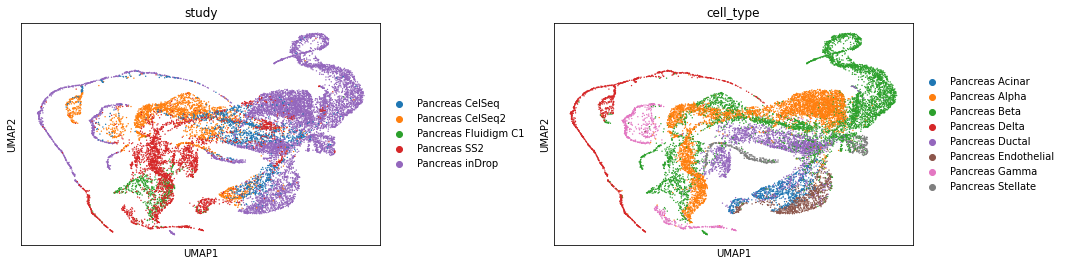

In [7]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

In [8]:
adata.obs['size_factors'] = adata.X.sum(1)

In [9]:
enc = OneHotEncoder(sparse=False)
enc.fit(adata.obs['study'].to_numpy().reshape(-1, 1))

OneHotEncoder(sparse=False)

In [10]:
use_cuda = torch.cuda.is_available()

convert = {'obs':
           {'study': lambda c: enc.transform(c.to_numpy().reshape(-1, 1))}
          }

dataloader = AnnDataLoader(adata, batch_size=128, shuffle=True, convert=convert, use_cuda=use_cuda)

In [11]:
n_conds = len(adata.obs['study'].cat.categories)
cvae = CVAE(adata.n_vars, n_conds=n_conds, hidden_dims=[128, 128], latent_dim=10)

if use_cuda:
    cvae.cuda()

In [12]:
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(cvae.model, cvae.guide, optimizer, loss=pyro.infer.TraceMeanField_ELBO())

In [13]:
def train(svi, train_loader):
    epoch_loss = 0.
    for batch in train_loader:
        epoch_loss += svi.step(batch.X, batch.obs['study'], batch.obs['size_factors'])

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [14]:
NUM_EPOCHS = 200

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, dataloader)
    if epoch % 40 == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 1246.0922
[epoch 040]  average training loss: 697.6821
[epoch 080]  average training loss: 687.2877
[epoch 120]  average training loss: 683.8253
[epoch 160]  average training loss: 681.9577


In [15]:
full_data = dataloader.dataset[:]

In [16]:
adata.obsm['X_cvae'] = cvae.encoder(full_data.X, full_data.obs['study'])[:, :10].data.cpu().numpy()

In [17]:
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)

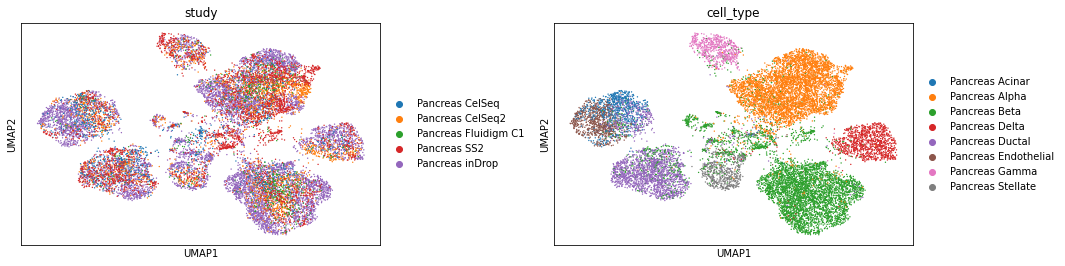

In [18]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)